In [36]:
import json
import os
import numpy as np
from tqdm import tqdm
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from operator import itemgetter
import pandas as pd
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.discrete.discrete_model import Poisson
import statsmodels.api as sm
import pytest
from statsmodels.stats.diagnostic import het_white
import scipy.stats as stats

In [37]:
suffix = ''
directory = os.path.join('..', 'data', f'requests{suffix}')
retrieved_data =  []
names = []
for file in os.listdir(directory):
    with open(os.path.join(directory, file), "r") as j:
        a = json.loads(j.read())
        retrieved_data.append(a)
        print('Added ', file)
        names.append(file.split('.')[0].split('q')[1])
retrieved_data = sorted(retrieved_data, key=itemgetter('citationCount'), reverse=True)

Added  req4Seasons.json
Added  reqA2D2.json
Added  reqA3D.json
Added  reqA9.json
Added  reqaiMotive.json
Added  reqAmodalCityscapes.json
Added  reqAMUSE.json
Added  reqAParametricTopViewRepresentationofComplexRoadScenes.json
Added  reqApolloScape.json
Added  reqArgoverse1Stereo.json
Added  reqArgoverse2Lidar.json
Added  reqArgoverse2MapChange.json
Added  reqArgoverse2MotionForecasting.json
Added  reqArgoverse2Sensor.json
Added  reqArgoverse3DTracking.json
Added  reqArgoverseMotionForecasting.json
Added  reqAugKITTI.json
Added  reqAutomatumOpenHighway.json
Added  reqAutonomousPlatformInertial.json
Added  reqBayArea.json
Added  reqBDD100k.json
Added  reqBDD100KAPS.json
Added  reqBeyondPASCAL.json
Added  reqBLVD.json
Added  reqBoreas.json
Added  reqBoschSmallTrafficLightsDataset.json
Added  reqBoschTL.json
Added  reqBoxCars116k.json
Added  reqBoxy.json
Added  reqBrain4Cars.json
Added  reqCADC.json
Added  reqCADP.json
Added  reqCaltechLanes.json
Added  reqCaltechPedestrian.json
Added  reqC

In [38]:
print(len(names))
df_name = pd.DataFrame(names)
df_name.to_csv(f'../output/retrieved_{len(names)}.csv', index=False, header=False, sep=",")

205


In [39]:
def calc_h_score(citations):
    """Calculates h-index"""
    if citations:
        citations = np.array(citations)
        n         = citations.shape[0]
        array     = np.arange(1, n+1)
        # reverse sorting
        citations = np.sort(citations)[::-1]
        # intersection of citations and k
        h_idx = np.max(np.minimum(citations, array))
        return h_idx
    else:
        return 0

In [40]:
class scoring:
    """For calculating h-indexes and absolut counts of citation-based features"""
    def __init__(self, o_paper, lower_bound, upper_bound, impact_year):
        self.o_paper = o_paper
        self.lower_bound = o_paper['paperInfo']['year'] - lower_bound # years prior to the publication used for calculating various scores
        self.upper_bound = o_paper['paperInfo']['year'] + upper_bound # year after publication used for calculating various scores
        self.impact_year = o_paper['paperInfo']['year'] + impact_year # year(s) after publication when we want to know a papers impact

    def number_citations_authors(self, author):
        """Returns a list where each entry is the number of citations a paper by a given author had up until the given year. Ignores citations without year resulting in different counts compared to the one given by the API."""
        ls_citations = []
        if 'authorsPapers' in self.o_paper['paperInfo']['authors'][author].keys():
            for paper in self.o_paper['paperInfo']['authors'][author]['authorsPapers']:
                #print(paper)
                if 'year' in paper and paper['year'] is not None and paper['year'] <= self.upper_bound:
                    numb_cit = 0
                    for citation in paper['citations']:
                        if 'year' in citation and citation['year'] is not None and self.upper_bound >= citation[
                            'year'] >= self.lower_bound:
                            numb_cit += 1
                    else:
                        ls_citations.append(numb_cit)
            return ls_citations
        else:
            return

    def number_citations_ref(self, dimension='references', dimension_papers='citations'):
        """Like number_citations but the list elements represent the citations the references/citations of a paper received."""
        ls_citations = []
        for paper in self.o_paper['paperInfo'][dimension]:
            if paper['year'] is not None and paper['year'] <= self.upper_bound and 'citations' in paper.keys():
                numb_cit = 0
                for citation in paper[dimension_papers]:
                    if citation['year'] is not None and self.upper_bound >= citation['year'] >= self.lower_bound:
                        numb_cit += 1
                else:
                    ls_citations.append(numb_cit)
        return ls_citations

    def just_citations(self):
        """Citation count of a paper prior to impact year and after lower bound"""
        numb_cit = 0
        for paper in self.o_paper['paperInfo']['citations']:
            if paper['year'] is not None and self.impact_year >= paper['year'] >= self.lower_bound:
                        numb_cit += 1
        return numb_cit

    def just_citations_non_cumulative(self):
        """Returns citation count for only a year instead of cumulatively"""
        numb_cit = 0
        for paper in self.o_paper['paperInfo']['citations']:
            #print(paper)
            if paper['year'] is not None and self.impact_year == paper['year']:
                        numb_cit += 1
                        #print((paper['year'] + self.impact_year))
        return numb_cit
    def reference_score(self):
        return calc_h_score(self.number_citations_ref())
    def citations_citations_score(self):
        return calc_h_score(self.number_citations_ref('citations', 'citations'))
    def citations_citations_sum(self):
        return np.sum(self.number_citations_ref('citations', 'citations'))
    def citations_single_author_score(self, author_number):
        number_citations = self.number_citations_authors(author_number)
        #if len(number_citations) > 0:
        return calc_h_score(number_citations)
        #else:
        #    return 0


In [41]:
impact_year = 9
ind_paper = 0
print(retrieved_data[ind_paper]['id'])
scorer = scoring(retrieved_data[ind_paper], 200, 0, impact_year)
print(impact_year, retrieved_data[ind_paper]['paperInfo']['year']+impact_year, scorer.just_citations_non_cumulative())

KITTI
9 2022 1032


When do citations take off

In [42]:
def citation_timeline_array(retrieved_data):
    """Columns are years, rows datasets. column 0 is year prior to publication. column 1 year of pub. etc. entries are #citations that year"""
    array = np.zeros([len(retrieved_data), 16])
    names = []
    for paper_idx, paper in enumerate(tqdm(retrieved_data)): #iterate over all papers
        names.append(paper['id'])
        if 'paperInfo' in retrieved_data[paper_idx].keys() and 'year' in retrieved_data[paper_idx]['paperInfo'].keys(): #check if paper has info on year
            array_idx = 0
            for impact_year in range(-1, 2022-retrieved_data[paper_idx]['paperInfo']['year']+1, 1):
                # iterates from 1 year prior to publication until today. e.g. kitti pub in 2012 2011-2022 -> last entry column 9
                scorer = scoring(paper, 200, 0, impact_year)
                array[paper_idx][array_idx] = scorer.just_citations() #calulate citation count of paper
                array_idx += 1
    return array, names
array, name = citation_timeline_array(retrieved_data)
array

100%|██████████| 205/205 [00:00<00:00, 4024.92it/s]


array([[  1.,   7.,  90., ...,   0.,   0.,   0.],
       [  0.,   1.,  10., ...,   0.,   0.,   0.],
       [  5.,  97., 480., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,  28., ...,   0.,   0.,   0.],
       [  0.,  13.,  36., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

In [43]:
#select three first years (approx. 50 papers haven't been out for 3 years so we loose them)
data = array
data = np.delete(data, np.s_[-12:], axis=1)
df = pd.DataFrame(data).set_axis(name)#
for column in range(df.shape[1]):
    if column >= 3:
        df = df[df[column] > 0]
data = np.array(df)

Plot time-line of the citation count of all papers

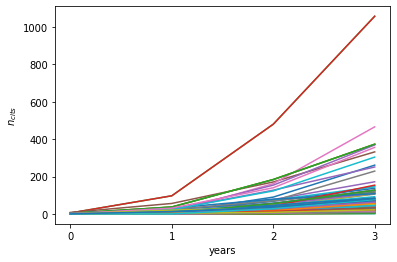

In [44]:
df_transpose = df.transpose()
df_transpose.plot()
plt.legend().remove()
plt.xlabel('years')
plt.ylabel('$n_{cits}$')
plt.xticks([*range(4)], [*range(4)])
plt.savefig('../output/citations_over_time.pdf')
plt.show()
#df_transpose

In [45]:
df_transpose

,KITTI,Cars,nuImages,nuScenes,Caltech Pedestrian,Oxford Robot Car,Waymo Open Perception,Mapillary Vistas,GTSRB,BDD100k,...,Toronto City,TRoM,Tsinghua Daimler Cyclist Detection,TUD Brussels,UAH-DriveSet,Unsupervised Llamas,USyd Campus,UTBM EU LTD,VPGNet,WoodScape
0,1.0,0.0,5.0,5.0,0.0,8.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7.0,1.0,97.0,97.0,11.0,56.0,9.0,4.0,14.0,13.0,...,0.0,0.0,3.0,2.0,0.0,0.0,1.0,3.0,0.0,13.0
2,90.0,10.0,480.0,480.0,77.0,171.0,162.0,70.0,34.0,74.0,...,17.0,0.0,14.0,27.0,3.0,4.0,5.0,9.0,28.0,36.0
3,261.0,34.0,1058.0,1058.0,172.0,332.0,466.0,229.0,50.0,145.0,...,58.0,3.0,23.0,63.0,11.0,11.0,8.0,22.0,77.0,82.0


Identify how many clusters are appropriate through an elbow plot

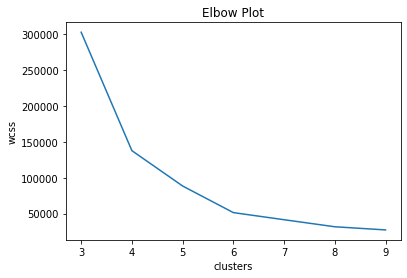

In [46]:
wcss = []
for k in range(3, 10):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(data)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)
plt.plot([*range(3, 10)], wcss)
plt.title('Elbow Plot')
plt.xlabel('clusters')
plt.ylabel('wcss')
plt.show()

Slect the last bend at 6 clusters. (Compared to 4 clusters, the bottom cluster is split in two, which makes a difference in year 3)

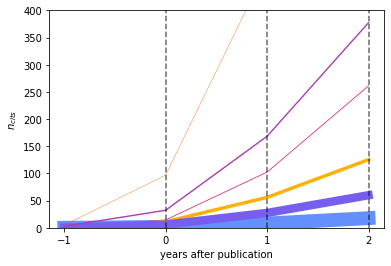

In [47]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(data)
clusters = kmeans.cluster_centers_
colors = ['#648fff', '#fe6100', '#dc267f', '#ffb000', '#785ef0', '#A740AE']
labels = pd.Series(kmeans.labels_)
labels = labels.value_counts(ascending=True).sort_index()
for label, cluster in enumerate(clusters):
    plt.plot([*range(-1, cluster.shape[0]-1)], cluster, alpha=1, label=label, color=colors[label] ,lw=labels.iloc[label]/5)
    #print(labels.iloc[label])
y_lim = 400
plt.ylim(0, y_lim)
plt.vlines(0, 0, y_lim, colors='black', linestyles='dashed', alpha=0.6)
plt.vlines(1, 0, y_lim, colors='black', linestyles='dashed', alpha=0.6)
plt.vlines(2, 0, y_lim, colors='black', linestyles='dashed', alpha=0.6)

#plt.hlines(100, 0, 4, colors='black', linestyles='dashed', alpha=0.6)
plt.xticks([*range(-1, cluster.shape[0]-1)])
plt.xlabel('years after publication')
plt.ylabel('$n_{cits}$')
plt.savefig('../output/citations_clustering.pdf', bbox_inches='tight')
plt.savefig('../output/citations_clustering.jpg', bbox_inches='tight')
plt.show()
# paper from 2020: -1=2019, 0=2020, 1=2021 2=2022

In [48]:
for clu in clusters:
    print(clu)

[ 0.07352941  1.66176471  7.95588235 17.75      ]
[   5.   97.  480. 1058.]
[  1.    14.5  102.5  261.25]
[  0.41176471  11.17647059  56.         125.41176471]
[ 0.20930233  5.90697674 27.39534884 59.95348837]
[  2.71428571  32.28571429 168.42857143 377.42857143]


In [49]:
labels = pd.Series(kmeans.labels_)
labels.value_counts(ascending=True)

1     2
2     4
5     7
3    17
4    42
0    69
dtype: int64

In [50]:
def create_modelling_df(retrieved_data, lower_bound, upper_bound, impact_year):
    """creates df for regression from retrieved data with sensor & altmetric. lower bound and upper bound give the respective first and last year for calculating scores. Impact year the year for which the citation count should be calculated"""
    array = np.zeros([len(retrieved_data), 4])
    for paper_idx, paper in enumerate(tqdm(retrieved_data)):
        if 'paperInfo' in retrieved_data[paper_idx].keys() and 'year' in retrieved_data[paper_idx]['paperInfo'].keys():
            array_idx = 0
            o_paper = retrieved_data[paper_idx]
            scorer = scoring(o_paper, lower_bound, upper_bound, impact_year)
            citation_c = scorer.just_citations()
            citations_citations_c = scorer.citations_citations_score()
            reference_score_c = scorer.reference_score()
            ls_author_scores = []
            for author_number, author in enumerate(o_paper['paperInfo']['authors']):
                single_author_score = scorer.citations_single_author_score(author_number)
                ls_author_scores.append(single_author_score)
            mean_author_score = np.mean(ls_author_scores[:])
            array[paper_idx][:4] = [citation_c, citations_citations_c, reference_score_c,  mean_author_score] #, first_author_score
            array_idx += 1
    names = []
    year = []
    sensors = []
    similar_age_3m = []
    row_w_missing_data = []
    missing_altmetirc_counter = 0
    missing_sensor_counter = 0

    culprit_sensor = 0
    culprit_altmetrics = 0
    for idx_paper, paper in enumerate(retrieved_data):
        missing_altmetirc_flag = False
        missing_sensor_flag = False
        names.append(paper['id'])
        year.append(paper['paperInfo']['year'])
        try:
            similar_age_3m_value = float(paper['altmetrics'][2]['similar_age_3m_percentile']['percentile'])
        except:
            row_w_missing_data.append(idx_paper)
            missing_altmetirc_counter += 1
            missing_altmetirc_flag = True
        try:
            sensors_value = int(len(list(paper['sensors'].split(','))))
        except:
            row_w_missing_data.append(idx_paper)
            missing_sensor_counter += 1
            missing_sensor_flag = True
            sensors_value = float('NaN')

        if not (missing_sensor_flag or missing_altmetirc_flag):
            sensors.append(sensors_value)
            similar_age_3m.append(similar_age_3m_value)

        if missing_altmetirc_flag and not missing_sensor_flag:
            culprit_altmetrics += 1
        if  missing_sensor_flag and not missing_altmetirc_flag:
            culprit_sensor += 1

    df = pd.DataFrame(array).set_axis(names)
    df['year'] = year
    df = df.drop(df.index[list(set(row_w_missing_data))])
    print("Missing Data (due to missing features):", len(row_w_missing_data))
    df['sensors'] = sensors
    df['similar_age_3m_percentile'] = similar_age_3m
    #df['similar_age_3m_percentile_square'] = df.similar_age_3m_percentile.pow(2)
    cols = list(df.columns)
    cols[:4] = ['citation_c', 'citations_citations_c', 'reference_score_c', 'mean_author_score'] #, 'first_author_score'
    df.columns = cols

    before = df.shape[0]
    df = df[df.year <= (2022-impact_year)]
    print('Missing Data (due to year):', (before-df.shape[0]))
    print('Missing values: altmetrics:', missing_altmetirc_counter, 'sensors', missing_sensor_counter)
    print('missing due to (other features available): sensors', culprit_sensor, 'altmetrics', culprit_altmetrics)
    return df

In [51]:
def convert_and_plot_data(df, drop='citations_citations_c', dependent_var='citation_c'):
    """clean up wrong value and convert to log scale"""
    try:
        replacement = df.at['Street Learn', 'frames'].replace(',', '')
        #print(replacement)
        df.at['Street Learn', 'frames'] = replacement
    except:
        print('No problem w street learn')
    modelling_df = df
    # modelling_df = modelling_df.drop(['BDD100k', 'Argoverse Motion Forecasting'], axis=0)
    modelling_df = modelling_df.drop([drop], axis=1)
    for idx_column, col in enumerate(modelling_df.columns):
        modelling_df[col] = modelling_df[col].astype("float")
    for idx, variable in enumerate(modelling_df):
        plt.scatter(modelling_df[variable], modelling_df[dependent_var])
        plt.xlabel(list(modelling_df.columns)[idx])
        plt.show()
    modelling_df[dependent_var] = np.log(modelling_df[dependent_var]+1)
    if 'frames' in modelling_df.columns:
        modelling_df.frames = np.log(modelling_df.frames+1)
    return modelling_df

def normalize(modelling_df, dependent_var='citation_c'):
    """normalize df before modelling"""
    for idx_column, col in enumerate(modelling_df.columns):
        if col != dependent_var:
                modelling_df[col] = (modelling_df[col]-modelling_df[col].mean())/(modelling_df[col].std())

    return modelling_df

def center(modelling_df, dependent_var='citation_c'):
    """normalize df before modelling"""
    for idx_column, col in enumerate(modelling_df.columns):
        if col != dependent_var:
                modelling_df[col] = modelling_df[col]-modelling_df[col].mean()
                plt.scatter(modelling_df[col], modelling_df[dependent_var])
                plt.xlabel(list(modelling_df.columns)[idx_column])
                plt.show()
    return modelling_df
def modelling(modelling_df, dependent_var='citation_c', show_summary=False):
    """do regression with statistics"""
    for idx_column, col in enumerate(modelling_df.columns):
        plt.scatter(modelling_df[col], modelling_df[dependent_var])
        plt.xlabel(list(modelling_df.columns)[idx_column])
        plt.show()
    independent_vars = modelling_df.drop([dependent_var], axis=1)
    X = add_constant(independent_vars)
    y = modelling_df[dependent_var]
    mod = sm.regression.linear_model.OLS(y, independent_vars.assign(intercept=1))
    res = mod.fit(cov_type="HC1")
    if show_summary:
        print(res.summary())
    test = sm.stats.diagnostic.het_breuschpagan(res.resid, res.model.exog)
    print('test', test)
    vif = pd.Series([variance_inflation_factor(X.values, i)
               for i in range(X.shape[1])],
              index=X.columns)
    print(vif)
    #perform White's test
    white_test = het_white(res.resid,  res.model.exog)

    #define labels to use for output of White's test
    labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']

    #print results of White's test
    print(dict(zip(labels, white_test)))
    fig = sm.qqplot(res.resid, stats.t, fit=True, line='45')
    plt.title('QQ_plot')
    plt.show()
    fitted_y = res.fittedvalues
    plot = sns.residplot(x=fitted_y, y=modelling_df[dependent_var], data=modelling_df, lowess=True)
    plt.show()
    for variable in independent_vars:
        plot = sns.residplot(x=independent_vars[variable], y=modelling_df[dependent_var], data=modelling_df, lowess=True)
        plt.show()
    return res, fitted_y, y, independent_vars

retrieved_data =  []
for file in os.listdir(directory):
    with open(os.path.join(directory, file), "r") as j:
        print(file)
        a = json.loads(j.read())
        retrieved_data.append(a)

retrieved_data = sorted(retrieved_data, key=itemgetter('citationCount'), reverse=True)

req4Seasons.json
reqA2D2.json
reqA3D.json
reqA9.json
reqaiMotive.json
reqAmodalCityscapes.json
reqAMUSE.json
reqAParametricTopViewRepresentationofComplexRoadScenes.json
reqApolloScape.json
reqArgoverse1Stereo.json
reqArgoverse2Lidar.json
reqArgoverse2MapChange.json
reqArgoverse2MotionForecasting.json
reqArgoverse2Sensor.json
reqArgoverse3DTracking.json
reqArgoverseMotionForecasting.json
reqAugKITTI.json
reqAutomatumOpenHighway.json
reqAutonomousPlatformInertial.json
reqBayArea.json
reqBDD100k.json
reqBDD100KAPS.json
reqBeyondPASCAL.json
reqBLVD.json
reqBoreas.json
reqBoschSmallTrafficLightsDataset.json
reqBoschTL.json
reqBoxCars116k.json
reqBoxy.json
reqBrain4Cars.json
reqCADC.json
reqCADP.json
reqCaltechLanes.json
reqCaltechPedestrian.json
reqCamVid.json
reqCarlaScenes.json
reqCARLAWildLifeCWL.json
reqCARRADA.json
reqCars.json
reqCCSAD.json
reqCityscapes3D.json
reqCityscapesDVPS.json
reqCODA.json
reqComma2k19.json
reqComma2k19LD.json
reqcommaai.json
reqComplexUrban.json
reqCooperative

Including altmetrics leads to 159 missing observations. Including sensors if frames is included leads to no missing values.

100%|██████████| 205/205 [00:24<00:00,  8.46it/s]


Missing Data (due to missing features): 76
Missing Data (due to year): 20
Missing values: altmetrics: 66 sensors 10
missing due to (other features available): sensors 8 altmetrics 64
No problem w street learn


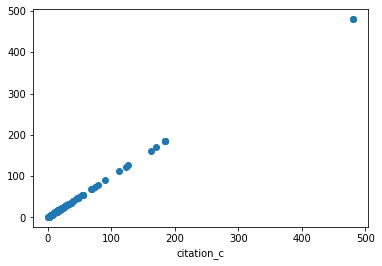

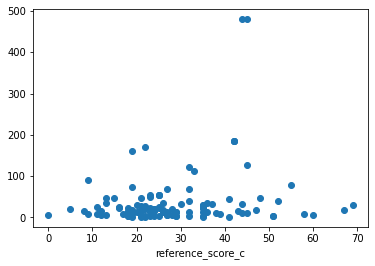

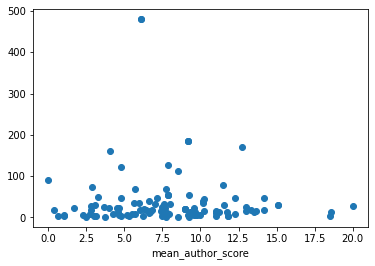

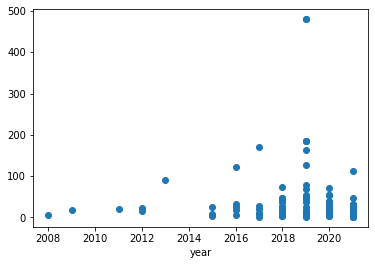

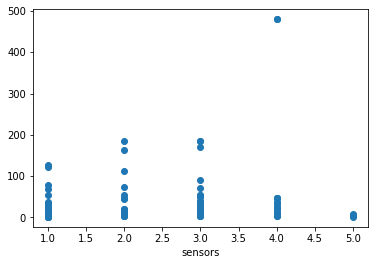

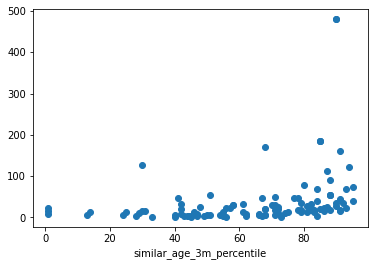

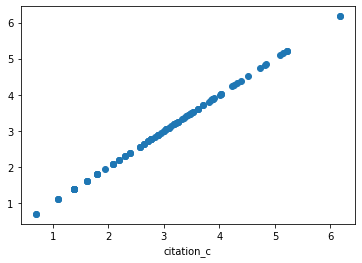

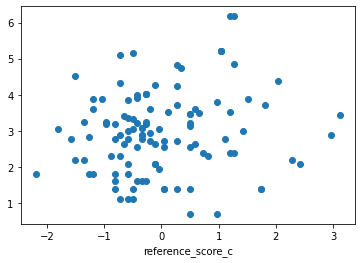

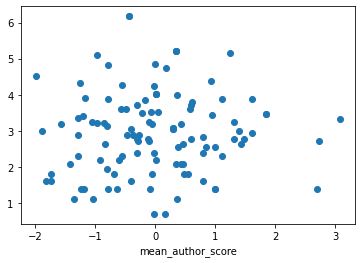

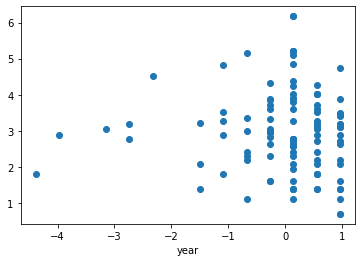

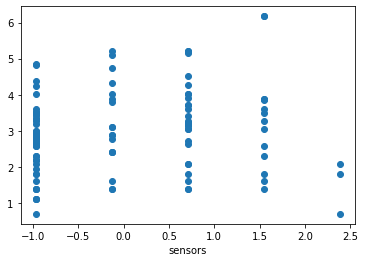

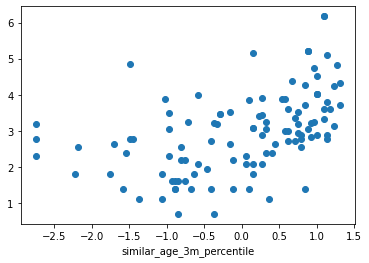

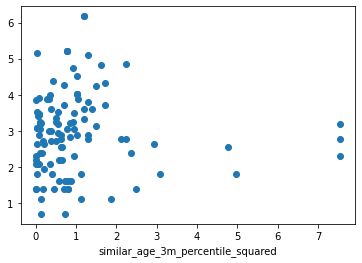

                            OLS Regression Results                            
Dep. Variable:             citation_c   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     9.585
Date:                Fri, 13 Jan 2023   Prob (F-statistic):           2.23e-08
Time:                        18:53:21   Log-Likelihood:                -146.08
No. Observations:                 111   AIC:                             306.2
Df Residuals:                     104   BIC:                             325.1
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
refere

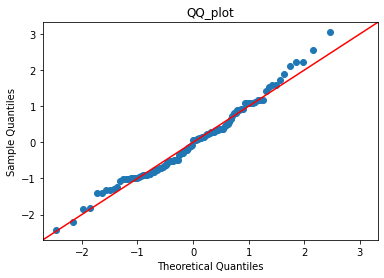

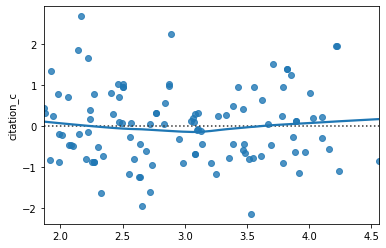

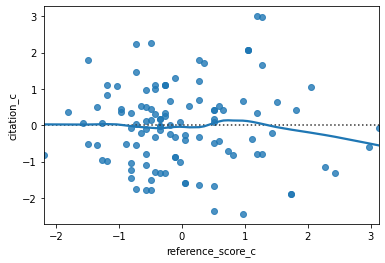

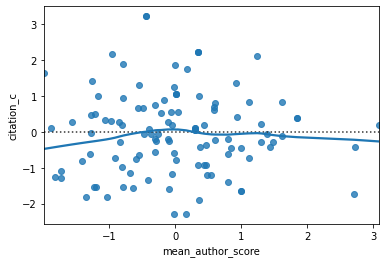

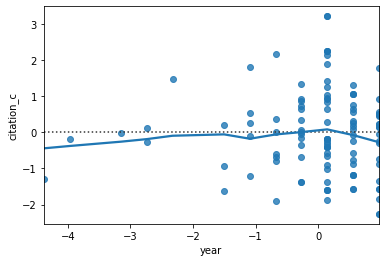

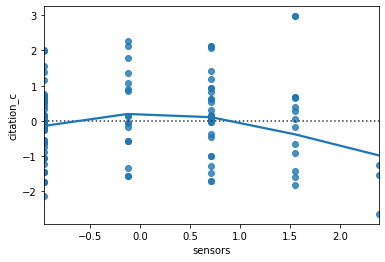

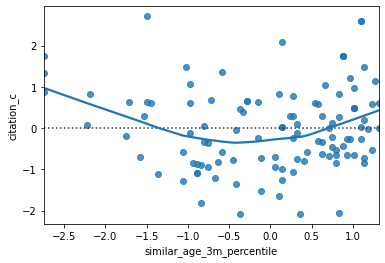

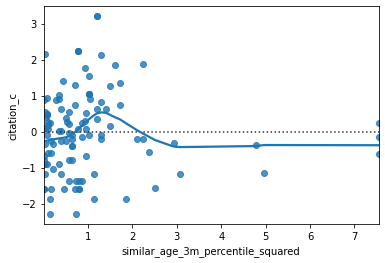

4468.735171468963


In [52]:
df = create_modelling_df(retrieved_data, 3, 0, 1)
modelling_df = convert_and_plot_data(df)
modelling_df_normalized = normalize(modelling_df)
modelling_df_normalized["similar_age_3m_percentile_squared"] = modelling_df_normalized.similar_age_3m_percentile.pow(2)
res_NO_frames, fitted_y, y_ols, x = modelling(modelling_df_normalized, show_summary=True)
print(sm.tools.eval_measures.mse(np.exp(fitted_y)-1, np.exp(y_ols))-1)

In [53]:
#save result
with open("../output/regression_NO_frames_years.csv", 'w') as csvFile:
    single = res_NO_frames.summary().as_csv()
    lns = single.split(";")
    for item in lns:
        csvFile.write(item.replace("=", ",") + os.linesep)

[3.7832   3.616864 3.459316 3.310556 3.170584 3.0394   2.917004 2.803396
 2.698576 2.602544 2.5153   2.436844 2.367176 2.306296 2.254204 2.2109
 2.176384 2.150656 2.133716 2.125564 2.1262   2.135624 2.153836 2.180836
 2.216624 2.2612   2.314564 2.376716 2.447656 2.527384 2.6159   2.713204
 2.819296 2.934176 3.057844 3.1903   3.331544 3.481576 3.640396 3.808004
 3.9844   4.169584 4.363556 4.566316 4.777864]


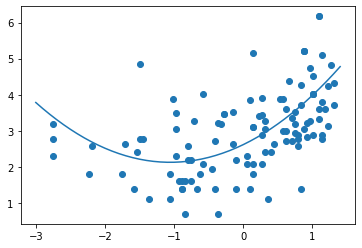

In [54]:
x = np.array([*range(-30, 15, 1)])/10
y = 2.6159 + 0.9291*x + 0.4394*x**2
print(y)
plt.plot(x, y)
plt.scatter(modelling_df_normalized.similar_age_3m_percentile, modelling_df_normalized.citation_c)
plt.show()

Making Citation Predictor with XGB - no good results

In [55]:
from sklearn import ensemble
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split


In [56]:
X_train, X_test, y_train, y_test = train_test_split(
    modelling_df.drop(['citation_c'], axis=1), modelling_df['citation_c'], test_size=0.3, random_state=13
)
X_train, X_fin, y_train, y_fin = train_test_split(
    X_test, y_test, test_size=0.3, random_state=13
)

In [57]:
params = {
    "n_estimators": 10,
    "max_depth": 20,
    "min_samples_split": 3,
    "learning_rate": 0.8,
    "loss": "squared_error",
}

In [58]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.8, max_depth=20, min_samples_split=3,
                          n_estimators=10)

In [59]:
mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
r2 = r2_score(y_test, reg.predict(X_test))
print("The R squared  (R2) on test set: {:.4f}".format(r2))

The mean squared error (MSE) on test set: 0.5819
The R squared  (R2) on test set: 0.5372


The mean absolute error (MAE) on test set: 16.3283
The mean squared error (MSE) on test set: 1622.6717


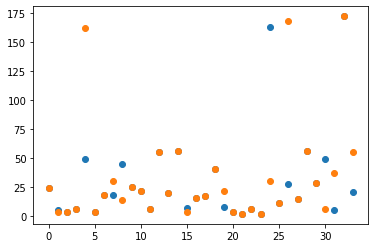

In [60]:

comparison = [np.exp(y_test), np.exp(reg.predict(X_test))]
mae = mean_absolute_error(comparison[0], comparison[1])
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))
mse = mean_squared_error(comparison[0], comparison[1])
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
plt.scatter([*range(len(y_test))], comparison[0])
plt.scatter([*range(len(y_test))], comparison[1])
plt.show()

The mean absolute error (MAE) on test set: 50.4694
The mean squared error (MSE) on test set: 5015.5307


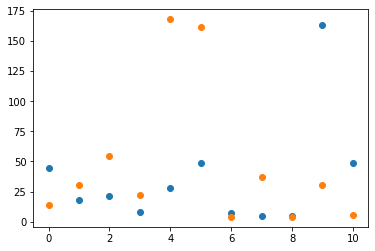

In [61]:
comparison = [np.exp(y_fin), np.exp(reg.predict(X_fin))]
mae = mean_absolute_error(comparison[0], comparison[1])
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))
mse = mean_squared_error(comparison[0], comparison[1])
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
plt.scatter([*range(len(comparison[0]))], comparison[0])
plt.scatter([*range(len(comparison[0]))], comparison[1])
plt.show()

### Table of Features and Influence Score of all papers from 2022

In [62]:
retrieved_data =  []
print('Importing data again')
for file in os.listdir(directory):
    with open(os.path.join(directory, file), "r") as j:
        a = json.loads(j.read())
        retrieved_data.append(a)
retrieved_data = sorted(retrieved_data, key=itemgetter('citationCount'), reverse=True)

Importing data again


In [63]:
for paper in retrieved_data:
    if paper['id'][0] == 'W':
        print(paper['id'])

Waymo Open Perception
Waymo Open Motion
WildDash
Waymo Block-NeRF
WildDash 2
WZ-traffic
WoodScape
Wuppertal Obstacle Sequences (WOS)


In [64]:
target = 'Wuppertal Obstacle Sequences (WOS)'
for paper in retrieved_data:
    if paper['id'] == target:
        print(paper['paperInfo']['year'])

2022


Make array with all features of all data to calculate percentile ranks

In [65]:
yr = 2022
array = np.empty([len(retrieved_data), 9])
array[:] = np.nan
names = []
'''
self.lower_bound = 2019 = o_paper['paperInfo']['year'] - (o_paper['paperInfo']['year'] - 2022 + 3)# years prior to the publication used for calculating various scores
self.upper_bound = 2022 = o_paper['paperInfo']['year'] + (-o_paper['paperInfo']['year']+2022) # year after publication used for calculating various scores
self.impact_year = 2022 = o_paper['paperInfo']['year'] + impact_year # year(s) after publication when we want to know a papers impact
'''
for paper_idx, o_paper in enumerate(tqdm(retrieved_data)):
    dist = 2022 - o_paper['paperInfo']['year'] #2022 - o_paper['paperInfo']['year']

    scorer = scoring(o_paper, -dist+2, dist, dist)
    reference = scorer.reference_score()
    citations_citations = scorer.citations_citations_score()
    citations = scorer.just_citations()

    print(paper_idx, o_paper['id'], 'citations', citations, 'year:', o_paper['paperInfo']['year'])
    print('scorer', scorer.lower_bound, scorer.upper_bound, scorer.impact_year)

    ls_author_scores = []
    names.append(o_paper['id'])
    for author_number, author in enumerate(o_paper['paperInfo']['authors']):
        single_author_score = scorer.citations_single_author_score(author_number)
        ls_author_scores.append(single_author_score)
    author = np.mean(ls_author_scores)
    try:
        score = o_paper['altmetrics'][0]['score']
    except:
        score = float("NaN")
    try:
        total_readers = o_paper['altmetrics'][3]['total_readers']
    except:
        total_readers = float("NaN")
    try:
        sensors_value = int(len(list(o_paper['sensors'].split(','))))
    except:
        sensors_value = float("NaN")
    try:
        if o_paper['frames'] != "-":
                frames_value = int(o_paper['frames'].replace(',', ''))
        else:
            frames_value = float("NaN")
    except:
                frames_value = float("NaN")
    publication = o_paper['paperInfo']['year']


    array[paper_idx][:] = [citations, citations_citations, total_readers, score, reference, author, sensors_value, frames_value, publication]

  0%|          | 1/205 [00:00<00:26,  7.58it/s]

0 KITTI citations 3056 year: 2013
scorer 2020 2022 2022
1 Cars citations 1323 year: 2013
scorer 2020 2022 2022
2 nuImages citations 1751 year: 2019
scorer 2020 2022 2022


  2%|▏         | 4/205 [00:00<00:10, 18.80it/s]

3 nuScenes citations 1751 year: 2019
scorer 2020 2022 2022
4 Caltech Pedestrian citations 340 year: 2009
scorer 2020 2022 2022
5 Oxford Robot Car citations 633 year: 2017
scorer 2020 2022 2022
6 Waymo Open Perception citations 907 year: 2019
scorer 2020 2022 2022


  4%|▍         | 8/205 [00:00<00:08, 22.08it/s]

7 Mapillary Vistas citations 541 year: 2017
scorer 2020 2022 2022
8 GTSRB citations 320 year: 2011
scorer 2020 2022 2022
9 BDD100k citations 627 year: 2018
scorer 2020 2022 2022
10 Beyond PASCAL citations 250 year: 2014
scorer 2020 2022 2022
11 Argoverse 3D Tracking citations 574 year: 2019
scorer 2020 2022 2022


  6%|▌         | 12/205 [00:00<00:07, 26.59it/s]

12 Argoverse Motion Forecasting citations 574 year: 2019
scorer 2020 2022 2022


  8%|▊         | 16/205 [00:00<00:06, 29.25it/s]

13 GTSDB citations 272 year: 2013
scorer 2020 2022 2022
14 LISA Traffic Sign citations 169 year: 2012
scorer 2020 2022 2022
15 TT100K citations 243 year: 2016
scorer 2020 2022 2022
16 CULane citations 365 year: 2017
scorer 2020 2022 2022
17 ApolloScape citations 246 year: 2018
scorer 2020 2022 2022


  9%|▉         | 19/205 [00:00<00:07, 24.65it/s]

18 Road Damage citations 194 year: 2018
scorer 2020 2022 2022
19 DDAD citations 269 year: 2019
scorer 2020 2022 2022


 11%|█         | 22/205 [00:00<00:07, 25.48it/s]

20 NoCrash citations 209 year: 2019
scorer 2020 2022 2022
21 Malaga Stereo and Laser Urban citations 91 year: 2014
scorer 2020 2022 2022
22 INTERACTION citations 195 year: 2019
scorer 2020 2022 2022


 12%|█▏        | 25/205 [00:01<00:18,  9.66it/s]

23 comma.ai citations 81 year: 2016
scorer 2020 2022 2022
24 Oxford Radar Robot Car citations 170 year: 2019
scorer 2020 2022 2022
25 India Driving citations 152 year: 2018
scorer 2020 2022 2022
26 LISA Traffic Light citations 69 year: 2016
scorer 2020 2022 2022


 15%|█▌        | 31/205 [00:01<00:13, 12.86it/s]

27 Bosch Small Traffic Lights Dataset citations 90 year: 2017
scorer 2020 2022 2022
28 Bosch TL citations 90 year: 2017
scorer 2020 2022 2022
29 DR(eye)VE citations 108 year: 2017
scorer 2020 2022 2022
30 KITTI-360 citations 81 year: 2015
scorer 2020 2022 2022
31 Nighttime Driving citations 112 year: 2018
scorer 2020 2022 2022
32 JAAD citations 106 year: 2017
scorer 2020 2022 2022
33 KAIST Multi-Spectral Day/Night citations 117 year: 2018
scorer 2020 2022 2022
34 Lyft Level5 Perception citations 127 year: 2020
scorer 2020 2022 2022
35 Lyft Level5 Prediction citations 127 year: 2020
scorer 2020 2022 2022


 21%|██        | 43/205 [00:02<00:06, 25.86it/s]

36 H3D citations 108 year: 2019
scorer 2020 2022 2022
37 A2D2 citations 120 year: 2020
scorer 2020 2022 2022
38 Waymo Open Motion citations 112 year: 2021
scorer 2020 2022 2022
39 Synscapes citations 93 year: 2018
scorer 2020 2022 2022
40 WildDash citations 86 year: 2018
scorer 2020 2022 2022
41 BoxCars116k citations 69 year: 2017
scorer 2020 2022 2022
42 Ground Truth Stixel citations 11 year: 2013
scorer 2020 2022 2022
43 Waymo Block-NeRF citations 89 year: 2022
scorer 2020 2022 2022
44 DBNet citations 52 year: 2018
scorer 2020 2022 2022
45 LostAndFound citations 63 year: 2016
scorer 2020 2022 2022
46 HD1K citations 59 year: 2016
scorer 2020 2022 2022
47 CADC citations 74 year: 2020
scorer 2020 2022 2022


 27%|██▋       | 56/205 [00:02<00:04, 30.03it/s]

48 HCI Challenging Stereo citations 10 year: 2012
scorer 2020 2022 2022
49 Fishyscapes citations 60 year: 2019
scorer 2020 2022 2022
50 NightOwls citations 44 year: 2018
scorer 2020 2022 2022
51 RELLIS-3D citations 50 year: 2020
scorer 2020 2022 2022
52 EuroCity Persons citations 114 year: 2019
scorer 2020 2022 2022
53 SemanticPOSS citations 49 year: 2020
scorer 2020 2022 2022
54 ONCE citations 47 year: 2021
scorer 2020 2022 2022
55 PointCloudDeNoising citations 35 year: 2019
scorer 2020 2022 2022


 34%|███▎      | 69/205 [00:02<00:03, 35.48it/s]

56 CADP citations 32 year: 2018
scorer 2020 2022 2022
57 Ford Autonomous Vehicle citations 41 year: 2020
scorer 2020 2022 2022
58 CARRADA citations 37 year: 2020
scorer 2020 2022 2022
59 D^2 City citations 34 year: 2019
scorer 2020 2022 2022
60 A Parametric Top-View Representation of Complex Road Scenes citations 30 year: 2018
scorer 2020 2022 2022
61 Comma2k19 citations 30 year: 2018
scorer 2020 2022 2022
62 RADIATE citations 27 year: 2020
scorer 2020 2022 2022
63 Talk2Car citations 30 year: 2019
scorer 2020 2022 2022
64 DIPLECS Autonomous Driving citations 18 year: 2015
scorer 2020 2022 2022
65 RoadAnomaly21 citations 31 year: 2021
scorer 2020 2022 2022
66 RoadObstacle21 citations 31 year: 2021
scorer 2020 2022 2022
67 PandaSet citations 29 year: 2021
scorer 2020 2022 2022
68 4Seasons citations 28 year: 2020
scorer 2020 2022 2022


 40%|███▉      | 81/205 [00:03<00:03, 38.78it/s]

69 DDD20: DAVIS Driving 2020 citations 26 year: 2020
scorer 2020 2022 2022
70 MTSD citations 26 year: 2019
scorer 2020 2022 2022
71 Bay Area citations 8 year: 2014
scorer 2020 2022 2022
72 DriveU Traffic Light citations 15 year: 2018
scorer 2020 2022 2022
73 Illumination Changes in a day citations 8 year: 2014
scorer 2020 2022 2022
74 Seasonal Variation citations 8 year: 2014
scorer 2020 2022 2022
75 Cityscapes 3D citations 22 year: 2020
scorer 2020 2022 2022
76 nuPlan citations 23 year: 2021
scorer 2020 2022 2022
77 RadarScenes citations 23 year: 2021
scorer 2020 2022 2022
78 KITTI-360 PanopticBEV citations 21 year: 2021
scorer 2020 2022 2022
79 nuScenes PanopticBEV citations 21 year: 2021
scorer 2020 2022 2022
80 Boxy citations 16 year: 2019
scorer 2020 2022 2022


 42%|████▏     | 86/205 [00:03<00:03, 35.46it/s]

81 ROAD citations 17 year: 2021
scorer 2020 2022 2022
82 Brain4Cars citations 77 year: 2015
scorer 2020 2022 2022
83 openDD citations 14 year: 2020
scorer 2020 2022 2022
84 MCity Data Collection citations 11 year: 2019
scorer 2020 2022 2022
85 Semantic KITTI citations 639 year: 2019
scorer 2020 2022 2022
86 SemanticUSL citations 13 year: 2021
scorer 2020 2022 2022
87 Cooperative Driving (CODD) citations 7 year: 2021
scorer 2020 2022 2022
88 PepScenes citations 6 year: 2020
scorer 2020 2022 2022


 46%|████▌     | 94/205 [00:03<00:03, 30.39it/s]

89 DriveSeg (MANUAL) citations 5 year: 2019
scorer 2020 2022 2022
90 DriveSeg (Semi-auto) citations 5 year: 2019
scorer 2020 2022 2022
91 WildDash 2 citations 4 year: 2022
scorer 2020 2022 2022
92 WZ-traffic citations 4 year: 2019
scorer 2020 2022 2022
93 Comma2k19 LD citations 2 year: 2022
scorer 2020 2022 2022
94 TJ4DRadSet citations 2 year: 2022
scorer 2020 2022 2022
95 Amodal Cityscapes citations 1 year: 2022
scorer 2020 2022 2022
96 LUMPI citations 1 year: 2022
scorer 2020 2022 2022
97 SceNDD citations 1 year: 2022
scorer 2020 2022 2022
98 aiMotive citations 0 year: 2022
scorer 2020 2022 2022
99 CarlaScenes citations 0 year: 2022
scorer 2020 2022 2022


 51%|█████     | 104/205 [00:03<00:03, 31.32it/s]

100 DRIV100 citations 1 year: 2021
scorer 2020 2022 2022
101 GLARE citations 0 year: 2022
scorer 2020 2022 2022
102 I see you citations 0 year: 2022
scorer 2020 2022 2022
103 MIT-AVT Clustered Driving Scene citations 1 year: 2020
scorer 2020 2022 2022
104 A*3D citations 53 year: 2019
scorer 2020 2022 2022
105 A9 citations 8 year: 2022
scorer 2020 2022 2022
106 AMUSE citations 8 year: 2013
scorer 2020 2022 2022
107 Argoverse 1 Stereo citations 574 year: 2019
scorer 2020 2022 2022


 53%|█████▎    | 108/205 [00:06<00:16,  6.01it/s]

108 Argoverse 2 Lidar citations 53 year: 2023
scorer 2020 2022 2022
109 Argoverse 2 Map Change citations 53 year: 2023
scorer 2020 2022 2022


 57%|█████▋    | 116/205 [00:07<00:12,  7.38it/s]

110 Argoverse 2 Motion Forecasting citations 53 year: 2023
scorer 2020 2022 2022
111 Argoverse 2 Sensor citations 53 year: 2023
scorer 2020 2022 2022
112 AugKITTI citations 0 year: 2022
scorer 2020 2022 2022
113 Automatum (Open Highway) citations 3 year: 2021
scorer 2020 2022 2022
114 Autonomous Platform Inertial citations 6 year: 2022
scorer 2020 2022 2022
115 BDD100K-APS citations 7 year: 2022
scorer 2020 2022 2022
116 BLVD citations 21 year: 2019
scorer 2020 2022 2022
117 Boreas citations 11 year: 2022
scorer 2020 2022 2022
118 Caltech Lanes citations 205 year: 2008
scorer 2020 2022 2022


 60%|██████    | 123/205 [00:07<00:07, 10.52it/s]

119 CamVid citations 473 year: 2009
scorer 2020 2022 2022
120 CARLA-WildLife (CWL) citations 0 year: 2022
scorer 2020 2022 2022
121 CCSAD citations 10 year: 2015
scorer 2020 2022 2022
122 Cityscapes-DVPS citations 58 year: 2020
scorer 2020 2022 2022
123 CODA citations 6 year: 2022
scorer 2020 2022 2022


 64%|██████▍   | 131/205 [00:07<00:04, 16.66it/s]

124 Complex Urban citations 104 year: 2019
scorer 2020 2022 2022
125 CrashD citations 3 year: 2021
scorer 2020 2022 2022
126 CURE-TSD citations 32 year: 2019
scorer 2020 2022 2022
127 CURE-TSR citations 29 year: 2017
scorer 2020 2022 2022
128 Daimler Pedestrian Path Prediction Benchmark citations 67 year: 2013
scorer 2020 2022 2022
129 Daimler Pedestrian Segmentation Benchmark citations 14 year: 2013
scorer 2020 2022 2022
130 Daimler Stereo Pedestrian Detection Benchmark citations 6 year: 2011
scorer 2020 2022 2022
131 DGL-MOTS citations 336 year: 2019
scorer 2020 2022 2022
132 ETH Pedestrian citations 143 year: 2008
scorer 2020 2022 2022


 67%|██████▋   | 138/205 [00:07<00:03, 20.81it/s]

133 exiD citations 2 year: 2022
scorer 2020 2022 2022
134 Five Roundabouts citations 87 year: 2018
scorer 2020 2022 2022
135 Ford CAMPUS citations 112 year: 2011
scorer 2020 2022 2022
136 Gated2Depth citations 22 year: 2019
scorer 2020 2022 2022
137 Gated2Gated citations 1 year: 2021
scorer 2020 2022 2022
138 GROUNDED citations 2 year: 2021
scorer 2020 2022 2022
139 GTA5 citations 793 year: 2016
scorer 2020 2022 2022


 71%|███████   | 145/205 [00:08<00:02, 24.37it/s]

140 HAD citations 27 year: 2019
scorer 2020 2022 2022
141 HDBD citations 0 year: 2022
scorer 2020 2022 2022
142 HDD citations 109 year: 2018
scorer 2020 2022 2022
143 HEV-I citations 61 year: 2018
scorer 2020 2022 2022
144 highD citations 364 year: 2018
scorer 2020 2022 2022
145 HSD citations 12 year: 2019
scorer 2020 2022 2022
146 IDDA citations 20 year: 2020
scorer 2020 2022 2022
147 inD citations 135 year: 2019
scorer 2020 2022 2022


 76%|███████▌  | 155/205 [00:08<00:01, 30.10it/s]

148 IPS300+ citations 3 year: 2021
scorer 2020 2022 2022
149 Ithaca365 citations 3 year: 2022
scorer 2020 2022 2022
150 KITTI-360-APS citations 7 year: 2022
scorer 2020 2022 2022
151 K-Lane citations 4 year: 2021
scorer 2020 2022 2022
152 K-Radar citations 1 year: 2022
scorer 2020 2022 2022
153 LIBRE citations 41 year: 2020
scorer 2020 2022 2022
154 LiDAR-Video Driving citations 52 year: 2018
scorer 2020 2022 2022
155 LISA Amazon-MLSL Vehicle Attributes (LAVA) citations 0 year: 2021
scorer 2020 2022 2022
156 LOKI citations 12 year: 2021
scorer 2020 2022 2022


 82%|████████▏ | 168/205 [00:08<00:00, 42.32it/s]

157 MAVD Multimodal Audio-Visual Detection citations 32 year: 2021
scorer 2020 2022 2022
158 MONA: The Munich Motion Dataset of Natural Driving citations 0 year: 2022
scorer 2020 2022 2022
159 MOTSynth citations 30 year: 2021
scorer 2020 2022 2022
160 MuIRan citations 92 year: 2020
scorer 2020 2022 2022
161 Multi Vehicle Stereo Event Camera citations 168 year: 2018
scorer 2020 2022 2022
162 NCLT citations 162 year: 2016
scorer 2020 2022 2022
163 One Thousand and One Hours citations 127 year: 2020
scorer 2020 2022 2022
164 OpenMPD citations 5 year: 2022
scorer 2020 2022 2022
165 PIE citations 97 year: 2019
scorer 2020 2022 2022
166 PREVENTION citations 23 year: 2019
scorer 2020 2022 2022
167 Provident Vehicle Detection at Night (PVDN) citations 2 year: 2021
scorer 2020 2022 2022
168 R3 Driving citations 0 year: 2021
scorer 2020 2022 2022
169 Raincouver citations 21 year: 2017
scorer 2020 2022 2022


 87%|████████▋ | 178/205 [00:08<00:00, 37.81it/s]

170 RANUS citations 17 year: 2018
scorer 2020 2022 2022
171 RoadSaW citations 1 year: 2022
scorer 2020 2022 2022
172 Rope3D citations 3 year: 2022
scorer 2020 2022 2022
173 rounD citations 45 year: 2020
scorer 2020 2022 2022
174 RUGD: Robot Unstructured Ground Driving citations 48 year: 2019
scorer 2020 2022 2022
175 R-U-MAAD citations 0 year: 2022
scorer 2020 2022 2022
176 ScribbleKITTI citations 6 year: 2022
scorer 2020 2022 2022
177 SeeingThroughFog citations 105 year: 2019
scorer 2020 2022 2022
178 SemKITTI-DVPS citations 58 year: 2020
scorer 2020 2022 2022
179 SHIFT citations 8 year: 2022
scorer 2020 2022 2022


 89%|████████▉ | 183/205 [00:10<00:02, 10.27it/s]

180 Small Obstacle citations 8 year: 2020
scorer 2020 2022 2022
181 SODA10M citations 8 year: 2021
scorer 2020 2022 2022
182 Stanford Drone citations 337 year: 2016
scorer 2020 2022 2022
183 Stanford Track Collection citations 34 year: 2011
scorer 2020 2022 2022
184 Street Hazards citations 72 year: 2022
scorer 2020 2022 2022
185 Street Learn citations 24 year: 2019
scorer 2020 2022 2022
186 Street Obstacle Sequences (SOS) citations 0 year: 2022
scorer 2020 2022 2022


100%|█████████▉| 204/205 [00:10<00:00, 27.87it/s]

187 Synthetic Discrepancy citations 63 year: 2019
scorer 2020 2022 2022
188 Synthia citations 933 year: 2016
scorer 2020 2022 2022
189 TAF-BW citations 12 year: 2018
scorer 2020 2022 2022
190 TITAN citations 53 year: 2020
scorer 2020 2022 2022
191 TME Motorway citations 22 year: 2012
scorer 2020 2022 2022
192 Toronto 3D citations 68 year: 2020
scorer 2020 2022 2022
193 Toronto City citations 53 year: 2016
scorer 2020 2022 2022
194 TRoM citations 6 year: 2017
scorer 2020 2022 2022
195 Tsinghua Daimler Cyclist Detection citations 33 year: 2016
scorer 2020 2022 2022
196 TUD Brussels citations 59 year: 2009
scorer 2020 2022 2022
197 UAH-DriveSet citations 60 year: 2016
scorer 2020 2022 2022
198 Unsupervised Llamas citations 26 year: 2019
scorer 2020 2022 2022
199 USyd Campus citations 8 year: 2020
scorer 2020 2022 2022
200 UTBM EU LTD citations 33 year: 2019
scorer 2020 2022 2022
201 VLMV - Vehicle Lane Merge Visual Benchmark citations 1 year: 2021
scorer 2020 2022 2022
202 VPGNet citation

100%|██████████| 205/205 [00:10<00:00, 19.15it/s]

204 Wuppertal Obstacle Sequences (WOS) citations 0 year: 2022
scorer 2020 2022 2022


In [66]:
df_features_IS = pd.DataFrame(array, columns=['citations', 'citations_citations', 'total_readers', 'score', 'reference', 'author', 'sensors_abs', 'frames_abs', 'publicationYear']).set_axis(names).drop_duplicates()
df_features_IS['cit'] = df_features_IS.citations.rank(pct = True)
df_features_IS['h-cit'] = df_features_IS.citations_citations.rank(pct = True)
df_features_IS['refs'] = df_features_IS.reference.rank(pct = True)
df_features_IS['authors'] = df_features_IS.author.rank(pct = True)
df_features_IS['sensors'] = df_features_IS.sensors_abs.rank(pct = True)
df_features_IS['frames'] = df_features_IS.frames_abs.rank(pct = True)
df_features_IS['Altmetric'] = df_features_IS.score.rank(pct = True)
df_features_IS['readers'] = df_features_IS.total_readers.rank(pct = True)
df_features_IS


,citations,citations_citations,total_readers,score,reference,author,sensors_abs,frames_abs,publicationYear,cit,h-cit,refs,authors,sensors,frames,Altmetric,readers
KITTI,3056.0,115.0,2012.0,12.25,9.0,30.250000,3.0,NaN,2013.0,1.000000,1.000000,0.055556,0.984848,0.768617,NaN,0.812865,1.000000
Cars,1323.0,66.0,366.0,3.00,23.0,18.500000,1.0,16185.0,2013.0,0.984848,0.969697,0.404040,0.883838,0.247340,0.296610,0.491228,0.871345
nuImages,1751.0,49.0,1260.0,23.08,63.0,6.800000,4.0,1200000.0,2019.0,0.992424,0.921717,0.959596,0.219697,0.925532,0.881356,0.926901,0.991228
nuScenes,1751.0,43.0,1260.0,23.08,63.0,6.800000,4.0,1400000.0,2019.0,0.992424,0.909091,0.959596,0.219697,0.925532,0.902542,0.926901,0.991228
Caltech Pedestrian,340.0,67.0,1.0,0.00,26.0,27.250000,1.0,1000000.0,2009.0,0.914141,0.979798,0.527778,0.974747,0.247340,0.860169,0.067251,0.038012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
USyd Campus,8.0,2.0,9.0,2.00,19.0,9.857143,5.0,NaN,2020.0,0.252525,0.204545,0.280303,0.459596,0.992021,NaN,0.380117,0.102339
UTBM EU LTD,33.0,8.0,64.0,0.25,23.0,14.500000,4.0,NaN,2019.0,0.502525,0.467172,0.404040,0.737374,0.925532,NaN,0.146199,0.432749
VLMV - Vehicle Lane Merge Visual Benchmark,1.0,1.0,NaN,NaN,38.0,3.500000,2.0,76500.0,2021.0,0.085859,0.151515,0.790404,0.058081,0.579787,0.593220,NaN,NaN
VPGNet,206.0,29.0,432.0,9.93,28.0,7.500000,1.0,21097.0,2017.0,0.863636,0.823232,0.588384,0.280303,0.247340,0.355932,0.766082,0.906433


In [67]:
df_features_IS = df_features_IS.iloc[:, -9:]


In [68]:
def influence_score(scores, weights=[1, 1, 1, 1, 1, 1, 1, 1], selected_features='default'):
    """Calculates Influence score of one paper based on given weights. IS=sum(weight_i*feature_i). Summ of weights is 1. Missing features are omitted and the remaining weights are rescaled so that their sum is equal to one. """
    weights = np.array(weights, dtype=float)
    #make array with all available features, i.e. exclude NaNs
    if selected_features == 'default': # no sensors
        selected_features = ['Altmetric', 'cit', 'h-cit', 'readers', 'refs', 'authors', 'frames']
    if selected_features == 'all':
        selected_features = scores.index
        #print(selected_features)
    ls_available_features = []
    for index_feature, feature in enumerate(selected_features):
        if not np.isnan(scores[feature]):
            ls_available_features.append((index_feature, feature))
            #print(feature)

    #scale weights
    if len(ls_available_features) != len(weights):
        weights_to_scale = np.zeros(len(ls_available_features))
        for index_insert, feature in enumerate(ls_available_features):
            weights_to_scale[index_insert] = weights[feature[0]]
        weights = weights_to_scale

    weights /= np.sum(weights)
    assert np.sum(weights) == pytest.approx(1)
    #print('Scaled weights:', weights)
    #print('Available features', len(ls_available_features), ls_available_features)
    #calculate score
    result = 0
    for index, feature in enumerate(ls_available_features):
        #print(result)
        #print(feature)
        result += weights[index]*scores[feature[1]]
        #print(feature[1], weights[index], scores[feature[1]])
    assert 0 <= result <= 1
    return result

In [69]:
influence_score(df_features_IS.iloc[0], selected_features='default')

0.8088782562466773

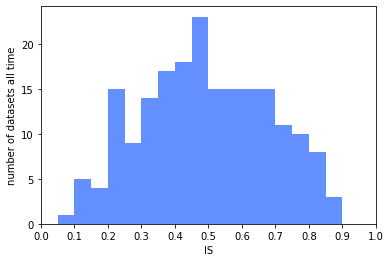

In [70]:
df_features_IS_all_time = df_features_IS.drop('publicationYear',axis=1).drop_duplicates()
ls_influence_score_all_time = []
for dataset in df_features_IS_all_time.index:
    ls_influence_score_all_time.append(influence_score(df_features_IS_all_time.loc[dataset])) #, weights=[0, 1, 0, 0, 0, 0, 0, 0]
ls_influence_score_all_time

plt.hist(ls_influence_score_all_time, bins=20, range=(0,1), color='#648fff')
plt.xlabel('IS')
plt.ylabel('number of datasets all time')
plt.xlim((0,1))
plt.xticks(np.array([*range(0, 11)])/10)
plt.savefig('../output/hist_all_at_influence_score.pdf')
plt.savefig('../output/hist_all_at_influence_score.jpg')
plt.show()

Subset with papers from 2022 and add column with influence score


In [71]:
df_features_IS_2022 = df_features_IS.loc[df_features_IS['publicationYear']==2022] #just datasets from 2022
df_features_IS_2022 = df_features_IS_2022.drop('publicationYear', axis=1)
ls_influence_score = []
for dataset in df_features_IS_2022.index:
    ls_influence_score.append(influence_score(df_features_IS_2022.loc[dataset]))
ls_influence_score
df_features_IS_2022['InfluenceScore'] = ls_influence_score
df_features_IS_2022 = df_features_IS_2022.sort_values('InfluenceScore', ascending=False)
df_features_IS_2022_to_save = df_features_IS_2022.round(decimals=2)
df_features_IS_2022_to_save.to_csv('../output/InfluenceScore2022.csv')
df_features_IS_2022

,cit,h-cit,refs,authors,sensors,frames,Altmetric,readers,InfluenceScore
Waymo Block-NeRF,0.702020,0.525253,0.949495,0.868687,NaN,NaN,1.000000,0.894737,0.823365
SHIFT,0.252525,0.204545,0.994949,0.888889,0.768617,0.940678,0.652047,0.421053,0.622098
Street Hazards,0.666667,0.575758,0.823232,0.924242,0.247340,0.161017,0.730994,0.450292,0.618886
KITTI-360-APS,0.227273,0.060606,0.686869,0.671717,0.247340,0.559322,0.973684,0.222222,0.485956
ScribbleKITTI,0.204545,0.151515,0.823232,0.969697,0.247340,0.322034,0.631579,0.017544,0.445735
BDD100K-APS,0.227273,0.060606,0.686869,0.671717,0.247340,0.101695,0.973684,0.222222,0.420581
Ithaca365,0.146465,0.151515,0.686869,0.212121,0.579787,0.822034,0.532164,0.257310,0.401211
CODA,0.204545,0.151515,0.752525,0.358586,0.247340,NaN,0.532164,0.345029,0.390727
Rope3D,0.146465,0.151515,0.823232,0.424242,0.579787,0.533898,0.245614,0.242690,0.366808
Comma2k19 LD,0.121212,0.151515,0.712121,0.558081,NaN,NaN,0.637427,0.017544,0.366317


In [72]:
df_features_IS_2022.max(axis=0)

cit               0.702020
h-cit             0.575758
refs              0.994949
authors           0.969697
sensors           0.925532
frames            0.940678
Altmetric         1.000000
readers           0.894737
InfluenceScore    0.823365
dtype: float64

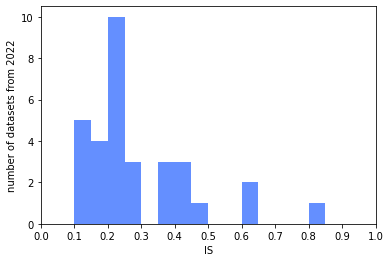

In [73]:
plt.hist(ls_influence_score, bins=20, range=(0,1), color='#648fff')
plt.xlabel('IS')
plt.ylabel('number of datasets from 2022')
plt.xlim((0,1))
plt.xticks(np.array([*range(0, 11)])/10)
plt.savefig('../output/hist_2022_influence_score.pdf')
plt.savefig('../output/hist_2022_influence_score.jpg')
plt.show()

### Top and Bottom 5 by citation count all time - time line

1. arrays with all features (citations, h-index citations, references, authors, sensors, frames)
2. percentile rank by year of each feature
3. Influence Score
4. Plot

#### 1st Create arrays

In [74]:
references_array = np.empty([len(retrieved_data), 15])
citations_array = np.empty([len(retrieved_data), 15])
citations_citations_array = np.empty([len(retrieved_data), 15])
author_array = np.empty([len(retrieved_data), 15])
citations_citations_sum_array = np.empty([len(retrieved_data), 15])
sensors_array = np.empty([len(retrieved_data), 15])
frames_array = np.empty([len(retrieved_data), 15])

references_array[:] = np.nan
citations_array[:] = np.nan
citations_citations_array[:] = np.nan
author_array[:] = np.nan
sensors_array[:] = np.nan
frames_array[:] = np.nan
citations_citations_sum_array[:] = np.nan

names = []
for paper_idx, o_paper in enumerate(tqdm(retrieved_data)):
    names.append(o_paper['id'])
    print(o_paper['id'])
    try:
        sensors_array[paper_idx, o_paper['paperInfo']['year']-2008:] =  int(len(list(o_paper['sensors'].split(','))))
    except:
        sensors_array[paper_idx, o_paper['paperInfo']['year']-2008:] =  float("NaN")
    try:
        if o_paper['frames'] != "-":
                frames_array[paper_idx, o_paper['paperInfo']['year']-2008:] = int(o_paper['frames'].replace(',', ''))
    except:
                frames_array[paper_idx, o_paper['paperInfo']['year']-2008:] = float("NaN")
    for index in range(14, 0, -1): #index = 16 = year 2022
        dist = 2008 + index - o_paper['paperInfo']['year']
        if dist < 0:
            break
        #print(dist)
        #scorer = scoring(o_paper, 3, dist, dist) # three years prior to publication, until dist. example: publication 2018. from 2015 to 2022
        scorer = scoring(o_paper, -dist+2, dist, dist)
        print(scorer.lower_bound, scorer.upper_bound, scorer.just_citations())
        ls_author_scores = []
        for author_number, author in enumerate(o_paper['paperInfo']['authors']):
            single_author_score = scorer.citations_single_author_score(author_number)
            ls_author_scores.append(single_author_score)
        author_array[paper_idx, index] = np.mean(ls_author_scores)
        references_array[paper_idx, index] = scorer.reference_score()
        citations_array[paper_idx, index] = scorer.just_citations()
        citations_citations_array[paper_idx, index] = scorer.citations_citations_score()
        citations_citations_sum_array[paper_idx, index] = scorer.citations_citations_sum()


  0%|          | 0/205 [00:00<?, ?it/s]

KITTI
2020 2022 3056
2019 2021 2893
2018 2020 2491
2017 2019 1821
2016 2018 1196
2015 2017 781
2014 2016 498
2013 2015 260
2012 2014 90
2011 2013 7


  1%|          | 2/205 [00:00<00:33,  6.07it/s]

Cars
2020 2022 1323
2019 2021 1108
2018 2020 838
2017 2019 556
2016 2018 329
2015 2017 189
2014 2016 85
2013 2015 34
2012 2014 10
2011 2013 1
nuImages
2020 2022 1751
2019 2021 1053
2018 2020 480
2017 2019 97
nuScenes
2020 2022 1751


  2%|▏         | 4/205 [00:00<00:22,  8.84it/s]

2019 2021 1053
2018 2020 480
2017 2019 97
Caltech Pedestrian
2020 2022 340
2019 2021 364
2018 2020 373
2017 2019 357
2016 2018 314
2015 2017 285
2014 2016 251
2013 2015 246


  3%|▎         | 7/205 [00:00<00:21,  9.41it/s]

2012 2014 232
2011 2013 246
2010 2012 238
2009 2011 172
2008 2010 77
2007 2009 11
Oxford Robot Car
2020 2022 633
2019 2021 595
2018 2020 506
2017 2019 324
2016 2018 169
2015 2017 56
Waymo Open Perception
2020 2022 907
2019 2021 465
2018 2020 162
2017 2019 9
Mapillary Vistas
2020 2022 541
2019 2021 497
2018 2020 385
2017 2019 229
2016 2018 70
2015 2017 4
GTSRB
2020 2022 320
2019 2021 343
2018 2020 356
2017 2019 299
2016 2018 217
2015 2017 142
2014 2016 98
2013 2015 77


  5%|▌         | 11/205 [00:01<00:17, 10.81it/s]

2012 2014 63
2011 2013 49
2010 2012 34
2009 2011 14
BDD100k
2020 2022 627
2019 2021 379
2018 2020 144
2017 2019 74
2016 2018 13
Beyond PASCAL
2020 2022 250
2019 2021 298
2018 2020 328
2017 2019 301
2016 2018 245
2015 2017 171
2014 2016 111
2013 2015 58
2012 2014 11
Argoverse 3D Tracking
2020 2022 574
2019 2021 370
2018 2020 184
2017 2019 37
Argoverse Motion Forecasting
2020 2022 574
2019 2021 370


  7%|▋         | 15/205 [00:01<00:15, 11.99it/s]

2018 2020 184
2017 2019 37
GTSDB
2020 2022 272
2019 2021 270
2018 2020 250
2017 2019 226
2016 2018 174
2015 2017 133
2014 2016 91
2013 2015 63
2012 2014 34
2011 2013 12
LISA Traffic Sign
2020 2022 169
2019 2021 215
2018 2020 225
2017 2019 217
2016 2018 175
2015 2017 176
2014 2016 142
2013 2015 116
2012 2014 58
2011 2013 23
2010 2012 5
TT100K
2020 2022 243
2019 2021 249
2018 2020 226
2017 2019 204
2016 2018 117
2015 2017 52
2014 2016 2
CULane
2020 2022 365
2019 2021 279
2018 2020 182
2017 2019 77


  9%|▉         | 19/205 [00:01<00:17, 10.53it/s]

2016 2018 19
2015 2017 1
ApolloScape
2020 2022 246
2019 2021 182
2018 2020 106
2017 2019 40
2016 2018 10
Road Damage
2020 2022 194
2019 2021 175
2018 2020 109
2017 2019 36
2016 2018 7


 12%|█▏        | 25/205 [00:02<00:10, 16.48it/s]

DDAD
2020 2022 269
2019 2021 150
2018 2020 44
2017 2019 7
NoCrash
2020 2022 209
2019 2021 135
2018 2020 68
2017 2019 18
Malaga Stereo and Laser Urban
2020 2022 91
2019 2021 105
2018 2020 104
2017 2019 92
2016 2018 69
2015 2017 53
2014 2016 30
2013 2015 17
2012 2014 3
INTERACTION
2020 2022 195
2019 2021 118
2018 2020 54
2017 2019 6
comma.ai
2020 2022 81
2019 2021 110
2018 2020 116
2017 2019 100
2016 2018 72
2015 2017 33
2014 2016 10
Oxford Radar Robot Car
2020 2022 170
2019 2021 110
2018 2020 48
2017 2019 5


 14%|█▎        | 28/205 [00:02<00:10, 17.46it/s]

India Driving
2020 2022 152
2019 2021 100
2018 2020 51
2017 2019 18
2016 2018 2
LISA Traffic Light
2020 2022 69
2019 2021 88
2018 2020 92
2017 2019 82
2016 2018 60
2015 2017 33
2014 2016 12
Bosch Small Traffic Lights Dataset
2020 2022 90
2019 2021 107
2018 2020 100
2017 2019 67
2016 2018 24
2015 2017 2
Bosch TL
2020 2022 90
2019 2021 107
2018 2020 100
2017 2019 67
2016 2018 24
2015 2017 2
DR(eye)VE
2020 2022 108


 15%|█▍        | 30/205 [00:02<00:10, 16.76it/s]

2019 2021 102
2018 2020 75
2017 2019 44
2016 2018 10
2015 2017 4
KITTI-360
2020 2022 81
2019 2021 72
2018 2020 50
2017 2019 57
2016 2018 48
2015 2017 29
2014 2016 7
2013 2015 0
Nighttime Driving
2020 2022 112
2019 2021 88


 18%|█▊        | 36/205 [00:02<00:08, 19.46it/s]

2018 2020 55
2017 2019 27
2016 2018 3
JAAD
2020 2022 106
2019 2021 96
2018 2020 71
2017 2019 32
2016 2018 11
2015 2017 0
KAIST Multi-Spectral Day/Night
2020 2022 117
2019 2021 89
2018 2020 53
2017 2019 20
2016 2018 3
Lyft Level5 Perception
2020 2022 127
2019 2021 55
2018 2020 8
Lyft Level5 Prediction
2020 2022 127
2019 2021 55
2018 2020 8
H3D
2020 2022 108
2019 2021 84
2018 2020 49
2017 2019 17
A2D2
2020 2022 120
2019 2021 70
2018 2020 24
Waymo Open Motion
2020 2022 112


 21%|██        | 43/205 [00:03<00:07, 22.56it/s]

2019 2021 24
Synscapes
2020 2022 93
2019 2021 78
2018 2020 45
2017 2019 16
2016 2018 2
WildDash
2020 2022 86
2019 2021 67
2018 2020 41
2017 2019 20
2016 2018 2
BoxCars116k
2020 2022 69
2019 2021 73
2018 2020 63
2017 2019 30
2016 2018 9
2015 2017 0
Ground Truth Stixel
2020 2022 11
2019 2021 17
2018 2020 22
2017 2019 40
2016 2018 48
2015 2017 52
2014 2016 41
2013 2015 29
2012 2014 15
2011 2013 4
Waymo Block-NeRF
2020 2022 89
DBNet
2020 2022 52
2019 2021 60
2018 2020 52


 24%|██▍       | 49/205 [00:03<00:06, 24.22it/s]

2017 2019 34
2016 2018 9
LostAndFound
2020 2022 63
2019 2021 45
2018 2020 30
2017 2019 22
2016 2018 10
2015 2017 5
2014 2016 1
HD1K
2020 2022 59
2019 2021 37
2018 2020 27
2017 2019 19
2016 2018 13
2015 2017 6
2014 2016 1
CADC
2020 2022 74
2019 2021 36
2018 2020 11
HCI Challenging Stereo
2020 2022 10
2019 2021 15
2018 2020 16
2017 2019 22
2016 2018 16
2015 2017 25
2014 2016 24
2013 2015 29
2012 2014 22
2011 2013 15
2010 2012 7
Fishyscapes
2020 2022 60
2019 2021 36
2018 2020 15
2017 2019 7
NightOwls
2020 2022 44


 27%|██▋       | 55/205 [00:03<00:06, 22.84it/s]

2019 2021 36
2018 2020 21
2017 2019 7
2016 2018 2
RELLIS-3D
2020 2022 50
2019 2021 20
2018 2020 1
EuroCity Persons
2020 2022 114
2019 2021 106
2018 2020 79
2017 2019 31
SemanticPOSS
2020 2022 49
2019 2021 24
2018 2020 11
ONCE
2020 2022 47
2019 2021 8


 31%|███       | 63/205 [00:03<00:04, 29.00it/s]

PointCloudDeNoising
2020 2022 35
2019 2021 11
2018 2020 2
2017 2019 0
CADP
2020 2022 32
2019 2021 26
2018 2020 16
2017 2019 9
2016 2018 0
Ford Autonomous Vehicle
2020 2022 41
2019 2021 21
2018 2020 9
CARRADA
2020 2022 37
2019 2021 17
2018 2020 1
D^2 City
2020 2022 34
2019 2021 29
2018 2020 15
2017 2019 3
A Parametric Top-View Representation of Complex Road Scenes
2020 2022 30
2019 2021 26
2018 2020 11
2017 2019 4
2016 2018 0
Comma2k19
2020 2022 30
2019 2021 20
2018 2020 12
2017 2019 4
2016 2018 1
RADIATE
2020 2022 27
2019 2021 3
2018 2020 1
Talk2Car
2020 2022 30
2019 2021 21
2018 2020 12
2017 2019 2
DIPLECS Autonomous Driving
2020 2022 18
2019 2021 17
2018 2020 13
2017 2019 10


 34%|███▍      | 70/205 [00:04<00:04, 28.81it/s]

2016 2018 9
2015 2017 6
2014 2016 3
2013 2015 0
RoadAnomaly21
2020 2022 31
2019 2021 5
RoadObstacle21
2020 2022 31
2019 2021 5
PandaSet
2020 2022 29
2019 2021 2
4Seasons
2020 2022 28
2019 2021 10
2018 2020 0
DDD20: DAVIS Driving 2020
2020 2022 26
2019 2021 14
2018 2020 3
MTSD
2020 2022 26
2019 2021 11
2018 2020 3
2017 2019 0
Bay Area
2020 2022 8


 38%|███▊      | 78/205 [00:04<00:03, 34.23it/s]

2019 2021 7
2018 2020 11
2017 2019 9
2016 2018 12
2015 2017 9
2014 2016 8
2013 2015 4
2012 2014 1
DriveU Traffic Light
2020 2022 15
2019 2021 16
2018 2020 13
2017 2019 10
2016 2018 3
Illumination Changes in a day
2020 2022 8
2019 2021 7
2018 2020 11
2017 2019 9
2016 2018 12
2015 2017 9
2014 2016 8
2013 2015 4
2012 2014 1
Seasonal Variation
2020 2022 8
2019 2021 7
2018 2020 11
2017 2019 9
2016 2018 12
2015 2017 9
2014 2016 8
2013 2015 4
2012 2014 1
Cityscapes 3D
2020 2022 22
2019 2021 7
2018 2020 1
nuPlan
2020 2022 23
2019 2021 3
RadarScenes
2020 2022 23
2019 2021 11
KITTI-360 PanopticBEV
2020 2022 21
2019 2021 2
nuScenes PanopticBEV
2020 2022 21
2019 2021 2
Boxy
2020 2022 16
2019 2021 11
2018 2020 8
2017 2019 1
ROAD
2020 2022 17


 40%|████      | 82/205 [00:04<00:03, 32.98it/s]

2019 2021 2
Brain4Cars
2020 2022 77
2019 2021 96
2018 2020 116
2017 2019 93
2016 2018 78
2015 2017 43
2014 2016 24
2013 2015 4
openDD
2020 2022 14
2019 2021 8
2018 2020 1
MCity Data Collection
2020 2022 11
2019 2021 8
2018 2020 4
2017 2019 0
Semantic KITTI
2020 2022 639
2019 2021 368
2018 2020 154
2017 2019 19


 44%|████▍     | 90/205 [00:04<00:04, 28.33it/s]

SemanticUSL
2020 2022 13
2019 2021 3
Cooperative Driving (CODD)
2020 2022 7
2019 2021 0
PepScenes
2020 2022 6
2019 2021 5
2018 2020 2
DriveSeg (MANUAL)
2020 2022 5
2019 2021 4
2018 2020 3
2017 2019 0
DriveSeg (Semi-auto)
2020 2022 5
2019 2021 4
2018 2020 3
2017 2019 0
WildDash 2
2020 2022 4
WZ-traffic
2020 2022 4
2019 2021 4
2018 2020 2


 51%|█████     | 105/205 [00:04<00:02, 45.56it/s]

2017 2019 0
Comma2k19 LD
2020 2022 2
TJ4DRadSet
2020 2022 2
Amodal Cityscapes
2020 2022 1
LUMPI
2020 2022 1
SceNDD
2020 2022 1
aiMotive
2020 2022 0
CarlaScenes
2020 2022 0
DRIV100
2020 2022 1
2019 2021 0
GLARE
2020 2022 0
I see you
2020 2022 0
MIT-AVT Clustered Driving Scene
2020 2022 1
2019 2021 1
2018 2020 0
A*3D
2020 2022 53
2019 2021 32
2018 2020 15
2017 2019 4
A9
2020 2022 8
AMUSE
2020 2022 8
2019 2021 9
2018 2020 8
2017 2019 9
2016 2018 4
2015 2017 5
2014 2016 3
2013 2015 3
2012 2014 1
2011 2013 0
Argoverse 1 Stereo
2020 2022 574
2019 2021 370
2018 2020 184
2017 2019 37
Argoverse 2 Lidar
Argoverse 2 Map Change
Argoverse 2 Motion Forecasting
Argoverse 2 Sensor
AugKITTI
2020 2022 0


 56%|█████▌    | 115/205 [00:05<00:01, 57.97it/s]

Automatum (Open Highway)
2020 2022 3
2019 2021 0
Autonomous Platform Inertial
2020 2022 6
BDD100K-APS
2020 2022 7
BLVD
2020 2022 21
2019 2021 19
2018 2020 13
2017 2019 5
Boreas
2020 2022 11
Caltech Lanes
2020 2022 205
2019 2021 230
2018 2020 275
2017 2019 260
2016 2018 250
2015 2017 207
2014 2016 172
2013 2015 145
2012 2014 116
2011 2013 88
2010 2012 59
2009 2011 35
2008 2010 17
2007 2009 5
CamVid
2020 2022 473
2019 2021 487
2018 2020 472
2017 2019 377
2016 2018 272
2015 2017 155
2014 2016 85


 60%|█████▉    | 122/205 [00:05<00:02, 38.46it/s]

2013 2015 58
2012 2014 51
2011 2013 47
2010 2012 42
2009 2011 31
2008 2010 17
2007 2009 6
CARLA-WildLife (CWL)
2020 2022 0
CCSAD
2020 2022 10
2019 2021 6
2018 2020 11
2017 2019 11
2016 2018 9
2015 2017 4
2014 2016 2
2013 2015 0
Cityscapes-DVPS
2020 2022 58
2019 2021 29
2018 2020 2
CODA
2020 2022 6
Complex Urban
2020 2022 104
2019 2021 78
2018 2020 43
2017 2019 13
CrashD
2020 2022 3
2019 2021 0
CURE-TSD
2020 2022 32
2019 2021 19
2018 2020 12
2017 2019 1


 62%|██████▏   | 127/205 [00:05<00:02, 38.05it/s]

CURE-TSR
2020 2022 29
2019 2021 28
2018 2020 29
2017 2019 17
2016 2018 8
2015 2017 0
Daimler Pedestrian Path Prediction Benchmark
2020 2022 67
2019 2021 89
2018 2020 91
2017 2019 86
2016 2018 65
2015 2017 55
2014 2016 39
2013 2015 24
2012 2014 8
2011 2013 0
Daimler Pedestrian Segmentation Benchmark
2020 2022 14
2019 2021 14
2018 2020 14
2017 2019 7
2016 2018 9
2015 2017 12
2014 2016 13
2013 2015 7
2012 2014 2
2011 2013 0
Daimler Stereo Pedestrian Detection Benchmark
2020 2022 6
2019 2021 6
2018 2020 16
2017 2019 22
2016 2018 31
2015 2017 37
2014 2016 35
2013 2015 36
2012 2014 27
2011 2013 22
2010 2012 10
2009 2011 2
DGL-MOTS
2020 2022 336


 64%|██████▍   | 132/205 [00:05<00:02, 30.36it/s]

2019 2021 248
2018 2020 126
2017 2019 23
ETH Pedestrian
2020 2022 143
2019 2021 139
2018 2020 176
2017 2019 186
2016 2018 204
2015 2017 182
2014 2016 174
2013 2015 145
2012 2014 128
2011 2013 105
2010 2012 104
2009 2011 97
2008 2010 68
2007 2009 34


 66%|██████▋   | 136/205 [00:06<00:02, 24.46it/s]

exiD
2020 2022 2
Five Roundabouts
2020 2022 87
2019 2021 70
2018 2020 44
2017 2019 19
2016 2018 5
Ford CAMPUS
2020 2022 112
2019 2021 112
2018 2020 106
2017 2019 95
2016 2018 77
2015 2017 66
2014 2016 54
2013 2015 55
2012 2014 52
2011 2013 36
2010 2012 20
2009 2011 6
Gated2Depth
2020 2022 22
2019 2021 20
2018 2020 10
2017 2019 4
Gated2Gated
2020 2022 1
2019 2021 1
GROUNDED
2020 2022 2
2019 2021 1
GTA5
2020 2022 793
2019 2021 757


 70%|███████   | 144/205 [00:06<00:02, 24.60it/s]

2018 2020 654
2017 2019 498
2016 2018 304
2015 2017 123
2014 2016 23
HAD
2020 2022 27
2019 2021 23
2018 2020 15
2017 2019 4
HDBD
2020 2022 0
HDD
2020 2022 109
2019 2021 111
2018 2020 83
2017 2019 48
2016 2018 7
HEV-I
2020 2022 61
2019 2021 59
2018 2020 41
2017 2019 13
2016 2018 0
highD
2020 2022 364
2019 2021 265
2018 2020 154
2017 2019 42
2016 2018 4
HSD
2020 2022 12
2019 2021 9
2018 2020 6
2017 2019 2


 76%|███████▌  | 155/205 [00:06<00:01, 34.08it/s]

IDDA
2020 2022 20
2019 2021 5
2018 2020 0
inD
2020 2022 135
2019 2021 64
2018 2020 25
2017 2019 0
IPS300+
2020 2022 3
2019 2021 0
Ithaca365
2020 2022 3
KITTI-360-APS
2020 2022 7
K-Lane
2020 2022 4
2019 2021 0
K-Radar
2020 2022 1
LIBRE
2020 2022 41
2019 2021 25
2018 2020 6
LiDAR-Video Driving
2020 2022 52
2019 2021 60
2018 2020 52
2017 2019 34
2016 2018 9
LISA Amazon-MLSL Vehicle Attributes (LAVA)
2020 2022 0
2019 2021 0
LOKI
2020 2022 12
2019 2021 3
MAVD Multimodal Audio-Visual Detection
2020 2022 32
2019 2021 7
MONA: The Munich Motion Dataset of Natural Driving
2020 2022 0
MOTSynth
2020 2022 30


 82%|████████▏ | 169/205 [00:06<00:00, 47.06it/s]

2019 2021 2
MuIRan
2020 2022 92
2019 2021 45
2018 2020 17
Multi Vehicle Stereo Event Camera
2020 2022 168
2019 2021 137
2018 2020 85
2017 2019 46
2016 2018 13
NCLT
2020 2022 162
2019 2021 145
2018 2020 119
2017 2019 91
2016 2018 59
2015 2017 25
2014 2016 10
One Thousand and One Hours
2020 2022 127
2019 2021 55
2018 2020 8
OpenMPD
2020 2022 5
PIE
2020 2022 97
2019 2021 70
2018 2020 28
2017 2019 0
PREVENTION
2020 2022 23
2019 2021 14
2018 2020 7
2017 2019 0
Provident Vehicle Detection at Night (PVDN)
2020 2022 2
2019 2021 1
R3 Driving
2020 2022 0
2019 2021 0
Raincouver
2020 2022 21
2019 2021 19
2018 2020 13
2017 2019 9
2016 2018 2
2015 2017 0
RANUS
2020 2022 17


 85%|████████▌ | 175/205 [00:07<00:00, 39.95it/s]

2019 2021 18
2018 2020 13
2017 2019 8
2016 2018 1
RoadSaW
2020 2022 1
Rope3D
2020 2022 3
rounD
2020 2022 45
2019 2021 19
2018 2020 3
RUGD: Robot Unstructured Ground Driving
2020 2022 48
2019 2021 24
2018 2020 2
2017 2019 0
R-U-MAAD
2020 2022 0
ScribbleKITTI
2020 2022 6
SeeingThroughFog
2020 2022 105
2019 2021 46
2018 2020 7
2017 2019 2


 88%|████████▊ | 180/205 [00:07<00:00, 35.21it/s]

SemKITTI-DVPS
2020 2022 58
2019 2021 29
2018 2020 2
SHIFT
2020 2022 8
Small Obstacle
2020 2022 8
2019 2021 3
2018 2020 1
SODA10M
2020 2022 8
2019 2021 0
Stanford Drone
2020 2022 337
2019 2021 343
2018 2020 296
2017 2019 185
2016 2018 81
2015 2017 29
2014 2016 1
Stanford Track Collection
2020 2022 34
2019 2021 45
2018 2020 53
2017 2019 61
2016 2018 59


 92%|█████████▏| 188/205 [00:07<00:00, 29.80it/s]

2015 2017 61
2014 2016 46
2013 2015 43
2012 2014 33
2011 2013 30
2010 2012 16
2009 2011 6
Street Hazards
2020 2022 72
Street Learn
2020 2022 24
2019 2021 27
2018 2020 14
2017 2019 8
Street Obstacle Sequences (SOS)
2020 2022 0
Synthetic Discrepancy
2020 2022 63
2019 2021 31
2018 2020 12
2017 2019 5
Synthia
2020 2022 933
2019 2021 915
2018 2020 806
2017 2019 592
2016 2018 356
2015 2017 140
2014 2016 31
TAF-BW
2020 2022 12
2019 2021 14
2018 2020 9
2017 2019 5
2016 2018 0
TITAN
2020 2022 53
2019 2021 33
2018 2020 20
TME Motorway
2020 2022 22
2019 2021 28
2018 2020 35
2017 2019 42
2016 2018 50
2015 2017 63
2014 2016 57
2013 2015 47
2012 2014 24


 94%|█████████▎| 192/205 [00:07<00:00, 21.08it/s]

2011 2013 12
2010 2012 2
Toronto 3D
2020 2022 68
2019 2021 40
2018 2020 7
Toronto City
2020 2022 53
2019 2021 74
2018 2020 102
2017 2019 98
2016 2018 58
2015 2017 17
2014 2016 0
TRoM
2020 2022 6
2019 2021 7
2018 2020 5


 95%|█████████▌| 195/205 [00:08<00:00, 18.08it/s]

2017 2019 3
2016 2018 0
2015 2017 0
Tsinghua Daimler Cyclist Detection
2020 2022 33
2019 2021 48
2018 2020 46
2017 2019 43
2016 2018 23
2015 2017 14
2014 2016 3
TUD Brussels
2020 2022 59
2019 2021 74
2018 2020 97
2017 2019 113
2016 2018 116
2015 2017 121
2014 2016 114
2013 2015 126
2012 2014 106


 99%|█████████▊| 202/205 [00:08<00:00, 19.33it/s]

2011 2013 106
2010 2012 86
2009 2011 63
2008 2010 27
2007 2009 2
UAH-DriveSet
2020 2022 60
2019 2021 68
2018 2020 60
2017 2019 37
2016 2018 11
2015 2017 3
2014 2016 0
Unsupervised Llamas
2020 2022 26
2019 2021 11
2018 2020 4
2017 2019 0
USyd Campus
2020 2022 8
2019 2021 5
2018 2020 1
UTBM EU LTD
2020 2022 33
2019 2021 22
2018 2020 9
2017 2019 3
VLMV - Vehicle Lane Merge Visual Benchmark
2020 2022 1
2019 2021 0
VPGNet
2020 2022 206
2019 2021 205
2018 2020 161
2017 2019 77
2016 2018 28


100%|██████████| 205/205 [00:08<00:00, 23.55it/s]

2015 2017 0
WoodScape
2020 2022 111
2019 2021 82
2018 2020 36
2017 2019 13
Wuppertal Obstacle Sequences (WOS)
2020 2022 0


In [75]:
#make list of tupels with (feature_name, array)
arrays_over_time = [('percentile $ref_{h3}$', references_array), ('percentile $n_{cit3}$', citations_array), ('percentile $cit_{h3}$', citations_citations_array), ('percentile $aut_{\mu h3}$', author_array), ('percentile $n_{sensors}$', sensors_array), ('percentile $n_{frames}$', frames_array)]

In [76]:
def percentile_rank(np_array):
    """takes np_array and calculates percentile ranks by column (year)"""
    df_percentile_ranks = pd.DataFrame(np_array)
    return np.array(df_percentile_ranks.rank(pct=True, axis=0))

#### 2nd calculate all percentile ranks

In [77]:
nan_array = np.empty([len(retrieved_data), 15])
nan_array[:] = np.nan
percentile_array = [('IS', nan_array)]
for array in arrays_over_time:
    percentile_array.append((array[0], percentile_rank(array[1])))
print('Feature:', percentile_array[2][0])
percentile_array[2][1]

Feature: percentile $n_{cit3}$


array([[       nan,        nan,        nan, ..., 1.        , 1.        ,
        1.        ],
       [       nan,        nan,        nan, ..., 0.9929078 , 0.99404762,
        0.98507463],
       [       nan,        nan,        nan, ..., 0.96099291, 0.98511905,
        0.99253731],
       ...,
       [       nan,        nan,        nan, ..., 0.83687943, 0.8452381 ,
        0.86567164],
       [       nan,        nan,        nan, ..., 0.53191489, 0.69047619,
        0.76616915],
       [       nan,        nan,        nan, ...,        nan,        nan,
        0.03482587]])

#### 3rd Iterate over created feature-arrays and calculate influence score

In [78]:
# selected_features = ['Altmetric', 'cit', 'h-cit', 'readers', 'refs', 'authors', 'frames']
#
for dataset in range(percentile_array[1][1].shape[0]):
    print(dataset, percentile_array[1][1].shape[0])
    for year in range(percentile_array[1][1].shape[1]):
        if not np.isnan(percentile_array[3][1][dataset][year]):
            scores = pd.Series({percentile_array[1][0]: percentile_array[1][1][dataset][year], percentile_array[2][0]: percentile_array[2][1][dataset][year], percentile_array[3][0]: percentile_array[3][1][dataset][year], percentile_array[4][0]: percentile_array[4][1][dataset][year], percentile_array[5][0]: percentile_array[5][1][dataset][year], percentile_array[6][0]: percentile_array[6][1][dataset][year]})
            print(scores)
            percentile_array[0][1][dataset][year] = influence_score(scores, selected_features='all')
#

0 205
percentile $ref_{h3}$        0.210526
percentile $n_{cit3}$        0.315789
percentile $cit_{h3}$        0.315789
percentile $aut_{\mu h3}$    0.052632
percentile $n_{sensors}$     0.921053
percentile $n_{frames}$           NaN
dtype: float64
percentile $ref_{h3}$        0.166667
percentile $n_{cit3}$        0.833333
percentile $cit_{h3}$        0.479167
percentile $aut_{\mu h3}$    0.041667
percentile $n_{sensors}$     0.916667
percentile $n_{frames}$           NaN
dtype: float64
percentile $ref_{h3}$        0.196429
percentile $n_{cit3}$        1.000000
percentile $cit_{h3}$        0.732143
percentile $aut_{\mu h3}$    0.035714
percentile $n_{sensors}$     0.875000
percentile $n_{frames}$           NaN
dtype: float64
percentile $ref_{h3}$        0.1250
percentile $n_{cit3}$        1.0000
percentile $cit_{h3}$        0.9125
percentile $aut_{\mu h3}$    0.0250
percentile $n_{sensors}$     0.8875
percentile $n_{frames}$         NaN
dtype: float64
percentile $ref_{h3}$        0.125

Select top and bottom 5

In [79]:
top_5 = pd.DataFrame(percentile_array[2][1]).dropna(thresh=4).drop_duplicates().sort_values(14, axis=0, ascending=False).iloc[:5, :]
# drop_duplicates removes nuScenes because it is a duplicate of nuImages (although frames differ slightly. Leeds to very confusing plots)
top_5

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,NaN,NaN,NaN,NaN,NaN,0.315789,0.833333,1.0,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.830435,0.960993,0.985119,0.992537
1,NaN,NaN,NaN,NaN,NaN,0.210526,0.333333,0.5,0.7625,0.942308,0.972973,0.982609,0.992908,0.994048,0.985075
188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5750,0.826923,0.986486,0.991304,0.985816,0.976190,0.980100
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.339130,0.843972,0.946429,0.975124


In [80]:
bottom_5 = pd.DataFrame(percentile_array[2][1]).dropna(thresh=4).sort_values(14, axis=0, ascending=True).iloc[:5, :]
bottom_5

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.052174,0.095745,0.154762,0.169154
90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.052174,0.134752,0.154762,0.184080
89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.052174,0.134752,0.154762,0.184080
194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.067308,0.040541,0.156522,0.170213,0.223214,0.206468
130,NaN,NaN,NaN,0.111111,0.333333,0.526316,0.541667,0.535714,0.6,0.576923,0.608108,0.521739,0.439716,0.199405,0.206468


In [81]:
top_and_bottom_5 = list(top_5.index) + list(bottom_5.index)[::-1]
top_bottom_names = []
for ids in top_and_bottom_5:
    top_bottom_names.append(names[ids])
print(top_and_bottom_5)
top_bottom_names

[0, 2, 1, 188, 6, 130, 194, 89, 90, 92]


['KITTI',
 'nuImages',
 'Cars',
 'Synthia',
 'Waymo Open Perception',
 'Daimler Stereo Pedestrian Detection Benchmark',
 'TRoM',
 'DriveSeg (MANUAL)',
 'DriveSeg (Semi-auto)',
 'WZ-traffic']

#### 4th Plot

10 10


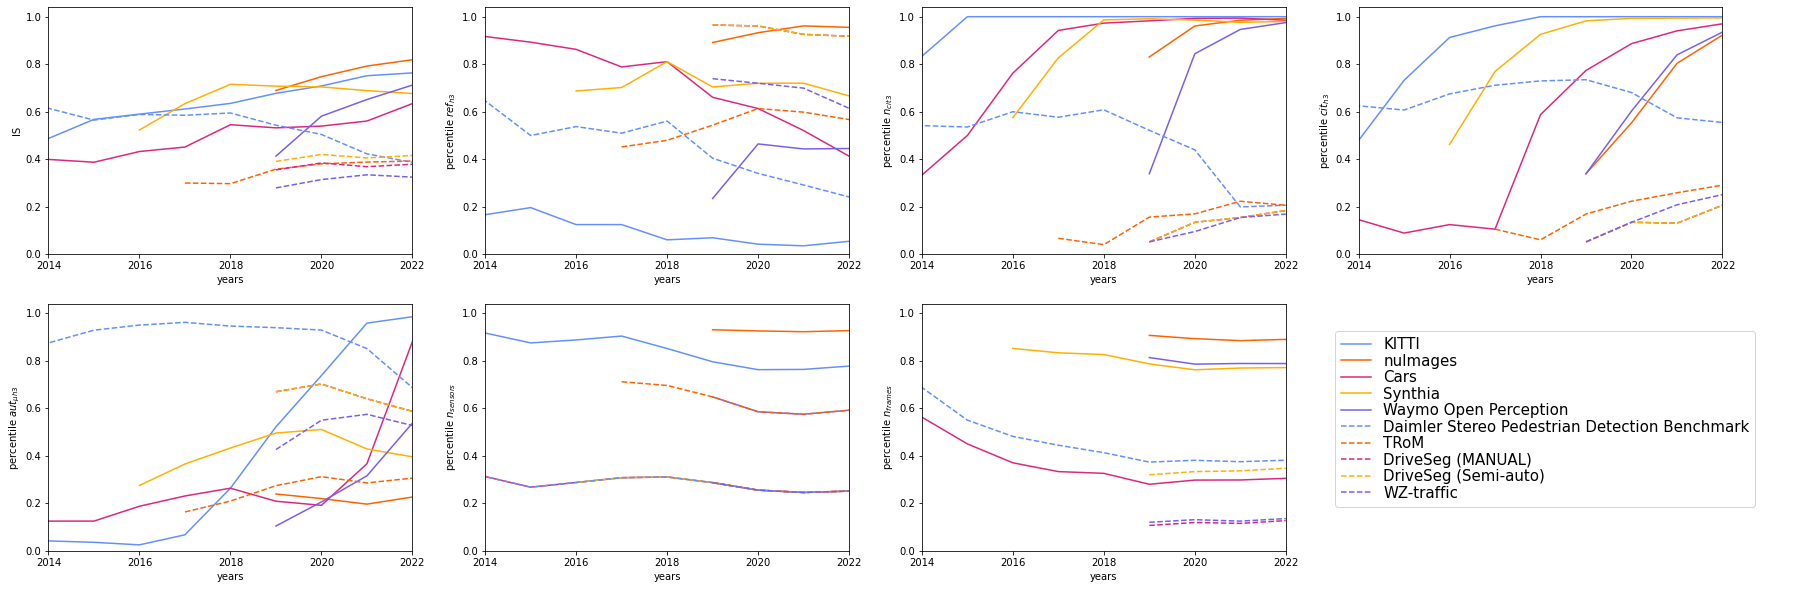

In [82]:
colors = ['#648fff', '#fe6100', '#dc267f', '#ffb000', '#785ef0', '#648fff', '#fe6100', '#dc267f', '#ffb000', '#785ef0']
print(len(colors), len(top_and_bottom_5))
fig, axs = plt.subplots(figsize=(30, 10), nrows=2, ncols=4) #20 8
#fig.subplots_adjust(wspace=0.2, hspace=0.2, top=0.95, bottom=0.1)
first = True
c = 0
plt.rcParams.update({'font.size': 18})
percentile_array.append('placeholder')
for ax, feature in zip(axs.flat, percentile_array):
    c += 1
    if c == 8:
        #ax.plot()
        #ax.legend(top_bottom_names, loc='best', labelspacing=0.1, fontsize='medium')
        ax.set_axis_off()
        continue
    for i_row, row in enumerate(top_and_bottom_5):
        if i_row >= 5:
            style='dashed'
        else:
            style='solid'
        ax.plot([*range(2008, 2023)], feature[1][row], label=names[row], color=colors[i_row], linestyle=style)
    ax.set(xlim=(2014, 2022), ylim=(0, 1.04), xticks=[*range(2014, 2023, 2)], xlabel='years', ylabel=feature[0])
    if first:
        #ax.legend(top_bottom_names, loc='lower center', labelspacing=0.1, fontsize='medium')
        first = False
fig.legend(top_bottom_names, loc=[0.74, 0.14], labelspacing=0.1, fontsize='small') #loc=[0.75, 0.1] [0.74, 0.14]
plt.savefig('../output/influence_scores_pr.pdf', bbox_inches='tight', pad_inches=0.1)
plt.savefig('../output/influence_scores_pr.jpg', bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.rcParams.update({'font.size': 10})